## Imports

In [1]:
import requests
#from http import HTTPStatus
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Activity 1

## Sub-activity: Open Data COVID-19 API

### task 1

In [2]:
# Solution for Task 1 ...
#Create a function, this function cite from the API documentation at:
#https://coronavirus.data.gov.uk/details/developers-guide/main-api.

def get_API_data(filters, structure):
    
    endpoint = "https://api.coronavirus.data.gov.uk/v1/data"
    

    api_params = {
        "filters": str.join(";", filters),
        "structure": json.dumps(structure, separators=(",", ":")),
        "format" : "json"
    }
    
    page_number = 1
    data = list()

    while True:
        # Adding page number to query params
        api_params["page"] = page_number

        response = requests.get(endpoint, params=api_params, timeout=10)
        
        if response.status_code == 429:  #After being blocked, set a wait time
            sleep = int(response.headers["Retry-After"])
            print(f'Too many requests, retry after { sleep } seconds.')
            time.sleep(sleep)
            continue
        elif response.status_code >= 400:
            raise RuntimeError(f"Request failed: { response.text }")
        elif response.status_code == 204:  #return a None content
            break
            
        
        current_data = response.json()
        page_data = current_data['data']
        
        data.extend(page_data)

        # The "next" attribute in "pagination" will be `None`
        # when we reach the end.
        if current_data["pagination"]["next"] is None:
            break

        page_number += 1


    #print("length:",current_data["length"],",maxPageLimit:",current_data["maxPageLimit"],",totalRecords:",current_data["totalRecords"])
    #print(current_data["pagination"])
    
    return data
      



In [3]:
#call the function
if __name__ == "__main__":
    query_filters = [
        f"areaType=region"
    ]

    query_structure = {
        "date":"date",
        "newCases":"newCasesByPublishDate"
    }

    json_data = get_API_data(query_filters, query_structure)
    print("JSON:")
    print(f"Length:", len(json_data))
    print("Data (first 3 items):", json_data[:3])

JSON:
Length: 12033
Data (first 3 items): [{'date': '2023-12-14', 'newCases': 0}, {'date': '2023-12-13', 'newCases': 143}, {'date': '2023-12-12', 'newCases': 128}]


### Task 2

In [4]:
# Solution for Task 2 ...
#call the function twice and set the output structure
if __name__ == "__main__":

    query_filters_nation = [
        f"areaType=nation"
    ]
    
    query_filters_region = [
        f"areaType=region"
    ]
    
    query_structure = {
        "date":"date",
        "areaName":"areaName",
        "dailyCases":"newCasesByPublishDate",
        "cumulativeCases":"cumCasesByPublishDate",
        "dailyDeaths":"newDeaths28DaysByPublishDate",
        "cumulativeDeaths":"cumDeaths28DaysByPublishDate",
        "cumulativeVaccinated":"cumPeopleVaccinatedSecondDoseByVaccinationDate",
        "vaccinationAge":"vaccinationsAgeDemographics"
    }

    results_json_national = get_API_data(query_filters_nation, query_structure)
    results_json_regional = get_API_data(query_filters_region, query_structure)
    print("JSON:")
    print(f"Length:", len(results_json_national))
    print("Data (first 1 items):", results_json_national[:1])
    print("JSON:")    
    print(f"Length:", len(results_json_regional))
    print("Data (first 1 items):", results_json_regional[:1])

JSON:
Length: 5373
Data (first 1 items): [{'date': '2023-12-14', 'areaName': 'England', 'dailyCases': 6065, 'cumulativeCases': 21023641, 'dailyDeaths': None, 'cumulativeDeaths': None, 'cumulativeVaccinated': None, 'vaccinationAge': []}]
JSON:
Length: 12036
Data (first 1 items): [{'date': '2023-12-14', 'areaName': 'North West', 'dailyCases': 0, 'cumulativeCases': 2868790, 'dailyDeaths': None, 'cumulativeDeaths': None, 'cumulativeVaccinated': None, 'vaccinationAge': []}]


## Sub-activity: Shaping the COVID data into different dataframes

### Task 3

In [5]:
# Solution for Task 3 : Comebine result
combined_results = results_json_national + results_json_regional
len(combined_results)

17409

### Task 4

In [6]:
# Solution for Task 4: set dataframe
covid_data = pd.DataFrame(combined_results)


covid_data = covid_data.rename(columns={
    "date": "date",
    "areaName": "name",
    "daily cases": "dailyCases,",
    "cumulative cases": "cumulativeCases",
    "daily deaths": "dailyDeaths",
    "cumulative deaths": "cumulativeDeaths",
    "cumulative vaccinated": "cumulativeVaccinated",
    "vaccination age": "vaccinationAge"
})

covid_data[:6]

,date,name,dailyCases,cumulativeCases,dailyDeaths,cumulativeDeaths,cumulativeVaccinated,vaccinationAge
0,2023-12-14,England,6065.0,21023641.0,NaN,NaN,NaN,[]
1,2023-12-13,England,0.0,21017576.0,NaN,NaN,41773077.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
2,2023-12-12,England,0.0,21017576.0,NaN,NaN,41773077.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
3,2023-12-11,England,0.0,21017576.0,NaN,NaN,41773077.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
4,2023-12-10,England,0.0,21017576.0,NaN,NaN,41773077.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."
5,2023-12-09,England,0.0,21017576.0,NaN,NaN,41773077.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy..."


### Task 5

In [7]:
# Solution for Task 5: erase all rows in which the name column have the value “England”
covid_data = covid_data[covid_data['name'] != "England"]
len(covid_data)

15995

### Task 6

In [8]:
# Solution for Task 6: change column name
covid_data.rename(columns={'name': 'area'}, inplace=True)

### Task 7

In [9]:
# Solution for Task 7 :Convert 'date' column to the datetime type
covid_data['date'] = pd.to_datetime(covid_data['date'])

### Task 8

In [10]:
# Solution for Task 8:Print a summary and find out missing
summary = covid_data.describe()
# if the data is null showing NaN, the data is missing
summary.loc['missing'] = covid_data.isnull().sum()
summary

,dailyCases,cumulativeCases,dailyDeaths,cumulativeDeaths,cumulativeVaccinated
count,1.558500e+04,1.558600e+04,12284.000000,12300.000000,1.225600e+04
mean,2.652577e+03,1.165706e+06,14.514083,12290.912114,3.389876e+06
std,4.710893e+04,1.023588e+06,30.199360,7289.212113,1.940047e+06
min,0.000000e+00,0.000000e+00,0.000000,1.000000,8.000000e+00
25%,0.000000e+00,2.128908e+05,0.000000,6436.750000,1.948140e+06
50%,1.870000e+02,8.945240e+05,3.000000,11469.000000,3.795800e+06
75%,1.944000e+03,2.007871e+06,15.000000,17833.000000,4.662062e+06
max,2.807692e+06,3.429182e+06,459.000000,30246.000000,7.039807e+06
missing,4.100000e+02,4.090000e+02,3711.000000,3695.000000,3.739000e+03


### Task 9

In [11]:
# Solution for Task 9 :replace missing values with the most recent 

cum_columns = ('cumulativeDeaths', 'cumulativeCases', 'cumulativeVaccinated')

#before use method='ffill' front-fill,data should be sorted
covid_data = covid_data.sort_values(by=['area', 'date'])
for col in cum_columns:
    covid_data[col] = covid_data.groupby('area')[col].fillna(method='ffill')

In [12]:
#To visualization better！！！
#make sure that the 'cumulativeDeaths', 'cumulativeCases', 'cumulativeVaccinated' for each region are incremented（or remain the same ） with the date
for col in cum_columns:
    covid_data[col] = covid_data.groupby('area')[col].cummax()
    
#And check the daily cases. The daily value of the day should be equal to the difference between the current day's cumulative value and the previous day's cumulative value

covid_data['dailyCasesSet'] = covid_data.groupby('area')['cumulativeCases'].diff().fillna(covid_data['dailyCases'])
covid_data['dailyDeathsSet'] = covid_data.groupby('area')['cumulativeDeaths'].diff().fillna(covid_data['dailyDeaths'])
dailyCases_error = covid_data[(covid_data['dailyCasesSet'] != covid_data['dailyCases'])& covid_data['dailyCases'].notna()]
dailyDeaths_error = covid_data[(covid_data['dailyDeathsSet'] != covid_data['dailyDeaths'])& covid_data['dailyDeaths'].notna()]


print(f'the input error dailyCases number of original dataset:{len(dailyCases_error)}')
print(f'the input error dailyDeaths number of original dataset:{len(dailyDeaths_error)}')

#correct the value of dailyCases and dailyDeaths
covid_data['dailyCases'] = covid_data['dailyCasesSet']
covid_data['dailyDeaths'] = covid_data['dailyDeathsSet']

covid_data.drop(['dailyCasesSet','dailyDeathsSet'], axis=1, inplace= True)


the input error dailyCases number of original dataset:490
the input error dailyDeaths number of original dataset:291


### Task 10

In [13]:
# Solution for Task 10：remove the rows that still have missing values in the cumulative metrics columns
covid_data.dropna(subset=cum_columns, inplace=True)
len(covid_data)

12965

In [14]:
#check
covid_data.isnull().sum()

date                    0
area                    0
dailyCases              0
cumulativeCases         0
dailyDeaths             0
cumulativeDeaths        0
cumulativeVaccinated    0
vaccinationAge          0
dtype: int64

### Task 11

In [15]:
# Solution for Task 11 ...
#Before rolling, duplicates should be drop
# For data analysis, drop duplicates by the way
covid_data['dailyCasesRollAvg'] = covid_data.groupby('area')['dailyCases'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)

covid_data['dailyDeathsRollAvg'] = covid_data.groupby('area')['dailyDeaths'].rolling(7, min_periods=1).mean().reset_index(0, drop=True)


In [16]:
covid_data.head()

,date,area,dailyCases,cumulativeCases,dailyDeaths,cumulativeDeaths,cumulativeVaccinated,vaccinationAge,dailyCasesRollAvg,dailyDeathsRollAvg
10208,2020-12-08,East Midlands,887.0,146710.0,64.0,4868.0,530.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy...",887.000000,64.00
10207,2020-12-09,East Midlands,994.0,147704.0,56.0,4924.0,541.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy...",940.500000,60.00
10206,2020-12-10,East Midlands,1610.0,149314.0,39.0,4963.0,549.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy...",1163.666667,53.00
10205,2020-12-11,East Midlands,1528.0,150842.0,38.0,5001.0,563.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy...",1254.750000,49.25
10204,2020-12-12,East Midlands,1315.0,152157.0,65.0,5066.0,563.0,"[{'age': '05_11', 'VaccineRegisterPopulationBy...",1266.800000,52.40


### Task 12

In [17]:
# Solution for Task 12: drop the columns 
covid_data.drop(['dailyCases', 'dailyDeaths'], axis=1, inplace=True)


### Task 13

In [18]:
# Solution for Task 13: create new dataframe
covid_data_vaccinations = pd.DataFrame(covid_data[['date', 'area', 'vaccinationAge']])


In [19]:
# and drop column
covid_data.drop(['vaccinationAge'], axis=1, inplace=True)
len(covid_data)

12965

### Task 14

In [20]:
# Solution for Task 14 ...
# Replace the empty list with NaN so that the explode method can work properly
covid_data_vaccinations['vaccinationAge'] = covid_data_vaccinations['vaccinationAge'].apply(lambda x: x if x else np.nan)

# Explode the 'vaccination_age' column into separate rows
covid_data_vaccinations = covid_data_vaccinations.explode('vaccinationAge')

# pick 'age'... 'cumVaccinationSecondDoseUptakeByVaccinationDatePercentage' key's value
col_names = ['age','VaccineRegisterPopulationByVaccinationDate:','cumPeopleVaccinatedCompleteByVaccinationDate',
            'newPeopleVaccinatedCompleteByVaccinationDate','cumPeopleVaccinatedFirstDoseByVaccinationDate',
            'newPeopleVaccinatedFirstDoseByVaccinationDate','cumPeopleVaccinatedSecondDoseByVaccinationDate',
           'newPeopleVaccinatedSecondDoseByVaccinationDate','cumVaccinationFirstDoseUptakeByVaccinationDatePercentage',
           'cumVaccinationCompleteCoverageByVaccinationDatePercentage','cumVaccinationSecondDoseUptakeByVaccinationDatePercentage']
for i in col_names:
    covid_data_vaccinations[i] = covid_data_vaccinations['vaccinationAge'].apply(lambda x: x.get(i) if isinstance(x, dict) else np.nan)


# Drop the original 'vaccination_age' column
covid_data_vaccinations = covid_data_vaccinations.drop(columns='vaccinationAge')

# Resulting DataFrame: covid_data_vaccinations_wide
covid_data_vaccinations_wide = covid_data_vaccinations   

covid_data_vaccinations_wide.head()

,date,area,age,VaccineRegisterPopulationByVaccinationDate:,cumPeopleVaccinatedCompleteByVaccinationDate,newPeopleVaccinatedCompleteByVaccinationDate,cumPeopleVaccinatedFirstDoseByVaccinationDate,newPeopleVaccinatedFirstDoseByVaccinationDate,cumPeopleVaccinatedSecondDoseByVaccinationDate,newPeopleVaccinatedSecondDoseByVaccinationDate,cumVaccinationFirstDoseUptakeByVaccinationDatePercentage,cumVaccinationCompleteCoverageByVaccinationDatePercentage,cumVaccinationSecondDoseUptakeByVaccinationDatePercentage
10208,2020-12-08,East Midlands,05_11,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10208,2020-12-08,East Midlands,12_15,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10208,2020-12-08,East Midlands,16_17,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10208,2020-12-08,East Midlands,18_24,NaN,4.0,0.0,22.0,6.0,4.0,0.0,0.0,0.0,0.0
10208,2020-12-08,East Midlands,25_29,NaN,33.0,0.0,89.0,42.0,33.0,0.0,0.0,0.0,0.0


## Sub-activity: Aggregating, plotting, and analysing


### Task 15

Text(0, 0.5, 'Cumulative Cases')

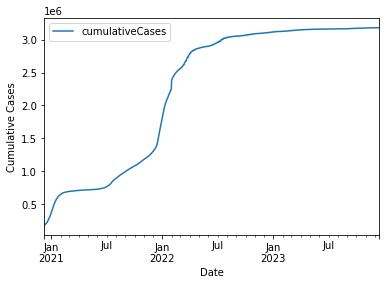

In [21]:
# Solution for Task 15:Show the cumulative cases in London as they evolve through time

# 1. Aggregate the data as an intermediate dataframe
intermediate_df = covid_data[covid_data['area'] == 'London']

# 2. Plot to visulised the transformed data
intermediate_df.plot('date','cumulativeCases')

plt.xlabel('Date')  
plt.ylabel('Cumulative Cases')

# 3.Answer the question posed with comment
# After July 2022, there is a period that the cases plateaued until now



### Task 16

Text(0, 0.5, 'Cumulative Cases')

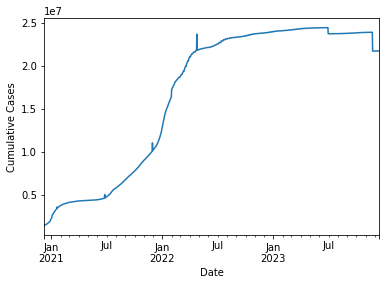

In [22]:
# Solution for Task 16: Show the evolution through time of cumulative cases summed over all areas.

# 1. Aggregate the data as an intermediate dataframe
intermediate_df = covid_data.groupby('date')['cumulativeCases'].sum()

# 2. Plot to visulised the transformed data
intermediate_df.plot()

plt.xlabel('Date')  
plt.ylabel('Cumulative Cases')

# 3.Answer the question posed with comment
# These two pattern of total Cumulative Cases and London Cumulative Cases are similar. After September 2022, there is a period that the cases plateaued
#!!However, there are a few special points that show a downward trend, and I need to check and process the data and draw again


In [23]:
#check special points date
daily_diff = intermediate_df.diff()
daily_diff[daily_diff <0]

date
2021-01-20    -130678.0
2021-06-26    -385027.0
2021-11-30    -896828.0
2022-04-25   -1859496.0
2023-06-30    -712944.0
2023-11-23   -2188589.0
Name: cumulativeCases, dtype: float64

In [24]:
date_filter = (covid_data['date'] >= pd.to_datetime('2023-11-23') - pd.Timedelta(days=3)) & (covid_data['date'] <= pd.to_datetime('2023-11-23') +pd.Timedelta(days=3))
covid_data[date_filter]  #Showing Scotland has not had any records since 2023-11-22

,date,area,cumulativeCases,cumulativeDeaths,cumulativeVaccinated,dailyCasesRollAvg,dailyDeathsRollAvg
9131,2023-11-20,East Midlands,1792739.0,17816.0,3600377.0,57.857143,0.0
9130,2023-11-21,East Midlands,1792788.0,17816.0,3600377.0,50.857143,0.0
9129,2023-11-22,East Midlands,1792838.0,17816.0,3600377.0,48.285714,0.0
9128,2023-11-23,East Midlands,1792890.0,17816.0,3600377.0,55.714286,0.0
9127,2023-11-24,East Midlands,1792971.0,17816.0,3600377.0,50.000000,0.0
...,...,...,...,...,...,...,...
6732,2023-11-22,Yorkshire and The Humber,2024121.0,19771.0,3989985.0,47.714286,0.0
6731,2023-11-23,Yorkshire and The Humber,2024161.0,19771.0,3989985.0,53.428571,0.0
6730,2023-11-24,Yorkshire and The Humber,2024206.0,19771.0,3989985.0,42.714286,0.0
6729,2023-11-25,Yorkshire and The Humber,2024206.0,19771.0,3989985.0,35.428571,0.0


In [25]:
# Find duplicate rows with the same 'time' and 'area'
duplicates = covid_data.duplicated(subset=['date', 'area'], keep=False)

# Print out duplicate rows
covid_data[duplicates]

,date,area,cumulativeCases,cumulativeDeaths,cumulativeVaccinated,dailyCasesRollAvg,dailyDeathsRollAvg
11346,2021-06-25,East of England,402874.0,13443.0,3024028.0,550.285714,0.000000
15045,2021-06-25,East of England,402874.0,13443.0,3024028.0,487.000000,0.000000
3202,2022-04-24,Scotland,1903803.0,11924.0,4079436.0,4443.000000,21.428571
4589,2022-04-24,Scotland,1903803.0,11924.0,4079436.0,4443.000000,21.428571
9106,2021-01-19,South West,169185.0,4303.0,47700.0,2643.857143,65.142857
12684,2021-01-19,South West,169185.0,4303.0,47700.0,2253.571429,53.285714
15044,2021-11-29,West Midlands,936382.0,15130.0,3825143.0,3503.428571,12.142857
16817,2021-11-29,West Midlands,936382.0,15134.0,3827728.0,2959.571429,10.428571


In [26]:
#show duplicates
date_filter = (covid_data['date'] >= pd.to_datetime('2021-11-29') - pd.Timedelta(days=3)) & (covid_data['date'] <= pd.to_datetime('2021-11-29') +pd.Timedelta(days=3))
area_filter = covid_data['area'] == 'West Midlands'
covid_data[date_filter & area_filter]

#Rows with 11346, 3202, 12684, and 15044 rows can be deleted
covid_data = covid_data.drop([11346, 3202, 12684, 15044], axis=0)


Text(0, 0.5, 'Cumulative Cases')

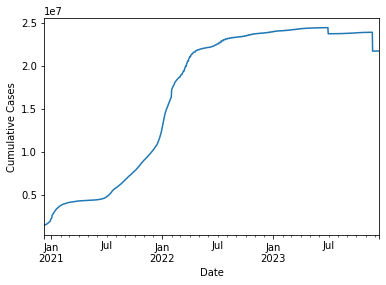

In [27]:
# show Task 16 again.
# 1. Aggregate the data as an intermediate dataframe
intermediate_df = covid_data.groupby('date')['cumulativeCases'].sum()

# 2. Plot to visulised the transformed data
intermediate_df.plot()

plt.xlabel('Date')  
plt.ylabel('Cumulative Cases')

# 3.Answer the question posed with comment
# These two pattern of total Cumulative Cases and London Cumulative Cases are similar. After September 2022, there is a period that the cases plateaued
#The downward trend is still present in the table because there is no record for Northern Ireland after 2023-06-29 and Scotland after 2023-11-22

### Task 17

Text(0, 0.5, 'Cumulative Cases')

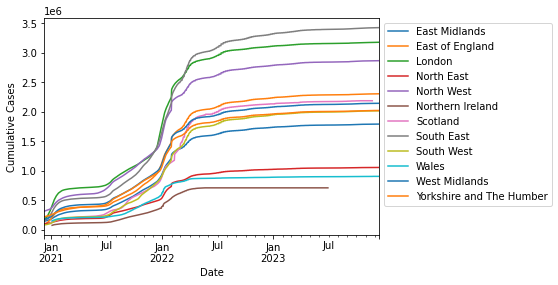

In [28]:
# Solution for Task 17: show us the evolution of cumulative cases of different areas as different lines in a plot

# 1. Aggregate the data as an intermediate dataframe
intermediate_df = covid_data[['date','area','cumulativeCases']]
intermediate_df.set_index('date', inplace=True)

# 2. Plot to visulised the transformed data
for area in covid_data['area'].unique():
    area_data = intermediate_df[intermediate_df['area'] == area]
    area_data['cumulativeCases'].plot(label=area)
    
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Date')  
plt.ylabel('Cumulative Cases')

# 3.Answer the question posed with comment
#CumulativeCases grew rapidly in the first half of 2022 in all countries, but flattened out after June 2022


### Task 18

Text(0, 0.5, 'Cumulative Deaths')

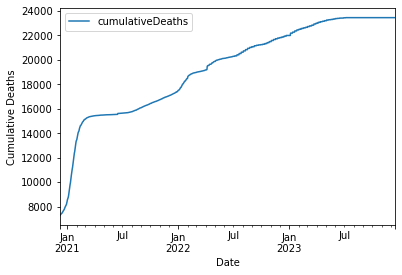

In [29]:
# Solution for Task 18:Show the evolution of cumulative deaths in London through time.

# 1. Aggregate the data as an intermediate dataframe
intermediate_df = covid_data[covid_data['area'] == 'London']

# 2. Plot to visulised the transformed data
intermediate_df.plot('date','cumulativeDeaths')

plt.xlabel('Date')  
plt.ylabel('Cumulative Deaths')

# 3.Answer the question posed with comment
#Since March 2021, the death ongoing trend has been broken

### Task 19

<AxesSubplot:xlabel='date'>

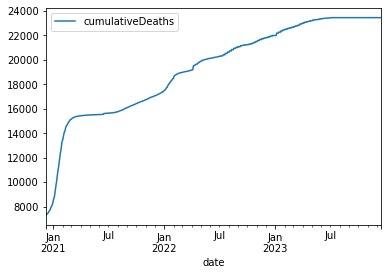

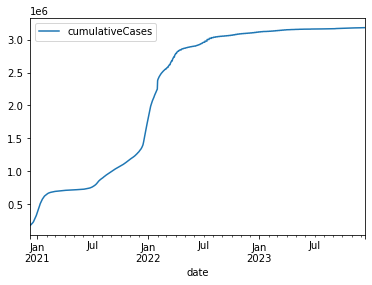

In [30]:
# Solution for Task 19: show 2 Graph and compare
# 1. Aggregate the data as an intermediate dataframe
intermediate_df = covid_data[covid_data['area'] == 'London']

# 2. Plot to visulised the transformed data
intermediate_df.plot('date','cumulativeDeaths')

intermediate_df.plot('date','cumulativeCases')
# 3.Answer the question posed with comment
#The trends in deaths and cases are similar in that their trends were broken in March 2021, and there was no significant increase in either value until September 2021

### Task 20

Text(0, 0.5, 'Cumulative Deaths Per Cases')

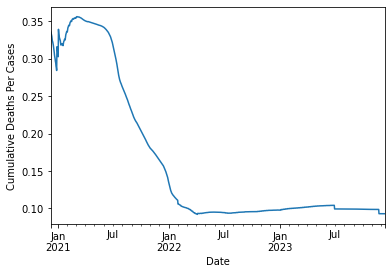

In [31]:
# Solution for Task 20: Show sum ratio between cumu- lative deaths and cumulative cases  over all regions/nations as a function of time.
# 1. Aggregate the data as an intermediate dataframe

# 2. Plot to visulised the transformed data
covid_data['cumulativeDeathsPerCases'] = covid_data['cumulativeDeaths'] / covid_data['cumulativeCases']
deaths_per_cases_over_time = covid_data.groupby('date')['cumulativeDeathsPerCases'].sum()
deaths_per_cases_over_time.plot()

plt.xlabel('Date')  
plt.ylabel('Cumulative Deaths Per Cases')

# 3.Answer the question posed with comment
#The cumulative death-to-case ratio has been on a declining trend since May 2021, until it began to level off after March 2022 and has since stabilized at around 0.1.

### Task 21


3.Answer the question posed with comment based on the data and plot from the last question:

Starting from April 2021, more and more people have been vaccinated, and almost all people have been vaccinated in September, hence graph’s inclination gets steeper during this period.

### Task 22

Text(0, 0.5, 'Cumulative Vaccinated')

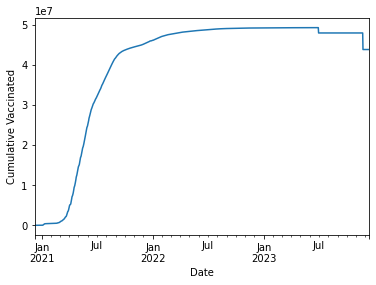

In [33]:
# Solution for Task 22: Show the sum of cumulative vaccinations over all areas as a function of time.

# 1. Aggregate the data as an intermediate dataframe
vaccination_totals_by_date = covid_data.groupby('date')['cumulativeVaccinated'].sum()

# 2. Plot to visulised the transformed data
vaccination_totals_by_date.plot()

plt.xlabel('Date')  
plt.ylabel('Cumulative Vaccinated')

# 3.Answer the question posed with comment
#Cumulative Vaccinated and Cumulative Deaths Per Cases show a negative correlation; as Cumulative Vaccinated increases, Cumulative Deaths Per Cases decreases.


### Task 23

Text(0, 0.5, 'Daily Cases Roll Avg')

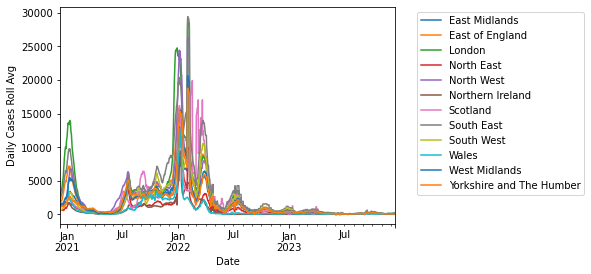

In [34]:
# Solution for Task 23: Show the daily cases rolling average as a function of time, separated by areas.

# 1. Aggregate the data as an intermediate dataframe
intermediate_df = covid_data[['date','area','dailyCasesRollAvg']]
intermediate_df.set_index('date', inplace=True)

# 2. Plot to visulised the transformed data
for area in covid_data['area'].unique():
    area_data = intermediate_df[intermediate_df['area'] == area]
    area_data['dailyCasesRollAvg'].plot(label=area)
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Date')  
plt.ylabel('Daily Cases Roll Avg')
# 3.Answer the question posed with comment
    #The image looks unusual, and I need to check the data before commenting

### Task 24

Text(0, 0.5, 'Daily Deaths Roll Avg')

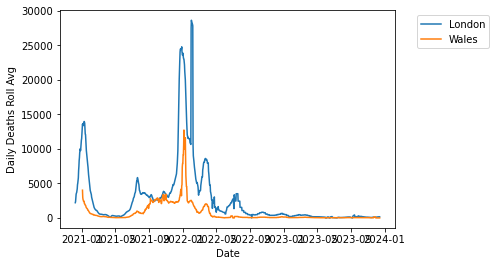

In [35]:
# Solution for Task 24: Show us the daily cases rolling average as a function of time for London and Wales.

# 1. Aggregate the data as an intermediate dataframe
london_data = covid_data[covid_data['area'] == 'London']
wales_data = covid_data[covid_data['area'] == 'Wales']

# 2. Plot to visulised the transformed data

plt.plot(london_data['date'], london_data['dailyCasesRollAvg'], label='London')
plt.plot(wales_data['date'], wales_data['dailyCasesRollAvg'], label='Wales')
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Date')  
plt.ylabel('Daily Deaths Roll Avg')

# 3.Answer the question posed with comment
#The frequency and intensity of fluctuations in London are greater than in Wales.
#The fluctuation peaks in London and Wales were around the same time, and the number of people in London was much larger than in Wales.


### Task 25

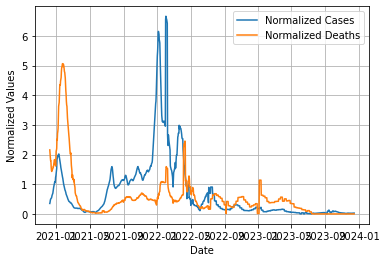

In [36]:
# Solution for Task 25 ...
# 1. Aggregate the data as an intermediate dataframe

# 2. Plot to visulised the transformed data
# Assuming we have rolling averages calculated as 'daily_cases_roll_avg' and 'daily_deaths_roll_avg'
covid_data['daily_cases_roll_avg_norm'] = covid_data['dailyCasesRollAvg'] / covid_data['dailyCasesRollAvg'].max()
covid_data['daily_deaths_roll_avg_norm'] = covid_data['dailyDeathsRollAvg'] / covid_data['dailyDeathsRollAvg'].max()

# Summing over all areas and plotting
total_cases_norm = covid_data.groupby('date')['daily_cases_roll_avg_norm'].sum()
total_deaths_norm = covid_data.groupby('date')['daily_deaths_roll_avg_norm'].sum()


plt.plot(total_cases_norm.index, total_cases_norm, label='Normalized Cases')
plt.plot(total_deaths_norm.index, total_deaths_norm, label='Normalized Deaths')


plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.legend()
plt.grid(True)

# 3.Answer the question posed with comment
#The daily trends of cases and deaths are similar, but the trend in deaths lags behind that of cases. This can be observed from the peaks and slopes of the two curves in the plot.

### Task 26

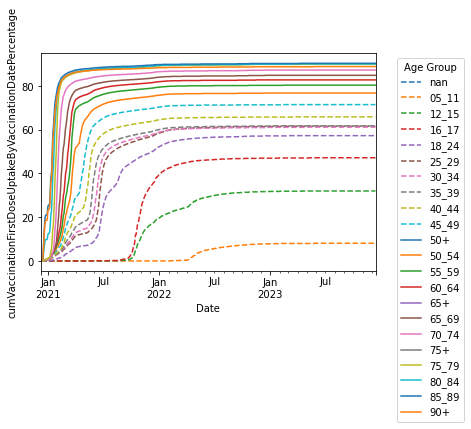

In [41]:
# Solution for Task 26: Vaccination First Dose Uptake Percentage by Age Group in London
# 1. Aggregate the data as an intermediate dataframe
london_df = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area'] == 'London']
scotland_df = covid_data_vaccinations_wide[covid_data_vaccinations_wide['area'] == 'Scotland']
    # Mould the London dataframe
pivot_london_df = london_df.pivot(index='date', 
                                        columns='age', 
                                        values='cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')

# 2. Plot to visulised the transformed data
# Plotting the London dataframe
# force the first ten lines to become dashed, to clarify repeat color of columns
pivot_london_df.plot(style=['--' for _ in range(10)])

plt.xlabel('Date')
plt.ylabel('cumVaccinationFirstDoseUptakeByVaccinationDatePercentage')
plt.legend(title='Age Group',bbox_to_anchor=(1.05, 1), loc='upper left')

# 3.Answer the question posed with comment
#Unequally, older people are vaccinated first, then middle-aged people, and minors last. It suggests that older people should be prioritized for vaccination because of evidence that older people are more likely to die from COVID-19.